En esta parte, estamos interesados en ver la temperatura como una serie de timepo, observando como ha cambiado esta a traves del tiempo, por eso estamos interesados en distintas metricas de los datos, primero solo en la temperatura anaual, para todo el planeta y para regiones específicas de este, utilizando serie s de Fourier quermeos observar como es que se comporta el power spectrum de estos datos 

In [14]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: C:\Users\danie\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import regionmask
import pandas as pd
import seaborn as sns
from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing
from sklearn.preprocessing import StandardScaler
import math
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from scipy.spatial import distance_matrix
import plotly.graph_objects as go
import kaleido
import requests
from io import StringIO
import pwlf
from scipy.stats import skew

In [16]:

fN = ("Datos\Land_and_Ocean_EqualArea.nc") 

ds = xr.open_dataset(fN)
years_approx = np.floor(ds['time'])
temp = ds['temperature'].groupby(years_approx).mean('time')
longitude = ds.variables['longitude'][:]  
latitude = ds.variables['latitude'][:]
time = ds.variables['time'][:]
land_mask = ds.variables['land_mask'][:]
temperature = ds.variables['temperature'][:]
climatology = ds.variables['climatology'][:]

In [17]:

# Convertir los datos de temperatura a un DataFrame
temperature_df = pd.read_csv("Datos/temperatura.csv",index_col="time")

# Revisar el resultado para asegurarse de que tiene el formato correcto
temperature_df.head()


point_1  point_2  point_3  point_4  point_5  point_6   point_7  \
time                                                                          
1850.041667      NaN      NaN      NaN      NaN      NaN      NaN  0.464756   
1850.125000      NaN      NaN      NaN      NaN      NaN      NaN -1.490464   
1850.208333      NaN      NaN      NaN      NaN      NaN      NaN -0.157294   
1850.291667      NaN      NaN      NaN      NaN      NaN      NaN -0.139167   
1850.375000      NaN      NaN      NaN      NaN      NaN      NaN -0.878162   

              point_8   point_9  point_10  ...  point_15975  point_15976  \
time                                       ...                             
1850.041667  0.681552  0.785687       NaN  ...          NaN          NaN   
1850.125000 -1.236933 -0.806517       NaN  ...          NaN          NaN   
1850.208333 -0.230608 -0.166150       NaN  ...          NaN          NaN   
1850.291667 -0.058191 -0.072071       NaN  ...          NaN          NaN   
1850.375000 -0.964870 -1.003502       NaN  ...          NaN          NaN   

             point_15977  point_15978  point_15979  point_15980  point_15981  \
time                                                                           
1850.041667          NaN          NaN          NaN          NaN          NaN   
1850.125000          NaN          NaN          NaN          NaN          NaN   
1850.208333          NaN          NaN          NaN          NaN          NaN   
1850.291667          NaN          NaN          NaN          NaN          NaN   
1850.375000          NaN          NaN          NaN          NaN          NaN   

             point_15982  point_15983  point_15984  
time                                                
1850.041667          NaN          NaN          NaN  
1850.125000          NaN          NaN          NaN  
1850.208333          NaN          NaN          NaN  
1850.291667          NaN          NaN          NaN  
1850.375000          NaN          NaN          NaN  

[5 rows x 15984 columns]

In [18]:
# Define las regiones AR6 utilizando regionmask
regions_ar6 = regionmask.defined_regions.ar6.all
temp_regions=pd.read_csv("Datos/temperaturaregionesipcc.csv",index_col="time")
temp_regions.head()

Region 0  Region 1  Region 2  Region 3  Region 4  Region 5  \
time                                                                      
1850.041667  0.136235 -1.330789  0.008371 -1.081719  1.557231  1.357871   
1850.125000 -2.766186  0.903567  0.457267 -1.672187 -0.238511  0.841829   
1850.208333 -0.290138 -1.243747 -0.128986 -2.131074 -1.220055 -0.509307   
1850.291667  0.248451 -1.428141 -1.840282 -0.240155 -3.188819 -1.529099   
1850.375000  0.256227 -1.246234 -1.437419 -0.391208 -1.781213 -1.727687   

             Region 6  Region 7  Region 8  Region 9  ...  Region 48  \
time                                                 ...              
1850.041667  0.177940  0.005466 -0.013133 -0.725280  ...  -0.754152   
1850.125000 -0.398261  0.037664 -0.005968 -0.345103  ...  -0.929530   
1850.208333 -0.421122  0.153145 -0.047957 -0.186628  ...  -0.766979   
1850.291667 -0.744390 -0.017132 -0.094589 -0.157292  ...  -0.403917   
1850.375000 -1.144015  0.459868  0.275922 -0.132240  ...   0.048388   

             Region 49  Region 50  Region 51  Region 52  Region 53  Region 54  \
time                                                                            
1850.041667   0.052812  -0.122649  -0.443389  -0.459247  -0.106958  -0.059162   
1850.125000   0.314541  -0.209424  -0.341581  -1.092278  -0.146366   0.671129   
1850.208333  -0.177736  -0.228850  -0.490354  -0.456664  -0.462185  -0.215787   
1850.291667  -0.471322  -0.146334  -0.470825  -0.542606  -0.543796  -0.349228   
1850.375000  -0.553649   0.094990  -0.382022  -0.085905  -0.260265  -0.337365   

             Region 55  Region 56  Region 57  
time                                          
1850.041667  -0.013802  -0.037105  -0.228845  
1850.125000   0.367911   0.032516  -0.330520  
1850.208333  -0.304528  -0.054666   0.138855  
1850.291667  -0.271987  -0.158646   0.081552  
1850.375000  -0.180721  -0.149693  -0.609608  

[5 rows x 58 columns]

In [19]:

land_mask_values = ds['land_mask'].values
unique_land_mask_values = np.unique(land_mask_values)
unique_land_mask_values

# Usar el valor entero (parte entera) de los tiempos flotantes como aproximación a "año"
# Esto asume que el año está representado directamente como un número flotante
dates = np.floor(ds['time'])

# Agrupar por estos años aproximados y calcular la media de la temperatura
temp = ds['temperature'].groupby(years_approx).mean('time')


# Separar las temperaturas en tierra y mar basándose en el 'land_mask'
# Considerar cualquier valor de 'land_mask' > 0 como tierra
is_land = land_mask_values > 0

# Temperaturas donde es tierra
temperature_land = ds['temperature'].where(is_land)

# Temperaturas donde es mar (negación de is_land)
temperature_sea = ds['temperature'].where(~is_land)

# Calcular la temperatura media anual para tierra y mar
annual_mean_temperature_land = temperature_land.groupby(dates).mean(dim=['time', 'map_points'])
annual_mean_temperature_sea = temperature_sea.groupby(dates).mean(dim=['time', 'map_points'])
# Calcular la desviación anual para tierra y mar
annual_std_temperature_land = temperature_land.groupby(dates).std(dim=['time', 'map_points'])
annual_std_temperature_sea = temperature_sea.groupby(dates).std(dim=['time', 'map_points'])
# Calcular la var anual para tierra y mar
annual_var_temperature_land = temperature_land.groupby(dates).var(dim=['time', 'map_points'])
annual_var_temperature_sea = temperature_sea.groupby(dates).var(dim=['time', 'map_points'])
annual_mean_temperature_land, annual_mean_temperature_sea


(<xarray.DataArray 'temperature' (time: 175)> Size: 700B
 array([-0.6116513 , -0.39715376, -0.47131598, -0.46754357, -0.34948713,
        -0.4413031 , -0.47487193, -0.7085741 , -0.42646918, -0.22443046,
        -0.56777054, -0.64176524, -0.9526564 , -0.35228318, -0.54712564,
        -0.35908064, -0.30264416, -0.19803175, -0.3843545 , -0.17906176,
        -0.3883681 , -0.4960546 , -0.3950557 , -0.2930972 , -0.19983791,
        -0.5749346 , -0.4199104 , -0.03559515,  0.28798628, -0.32406768,
        -0.4399538 , -0.23830725, -0.3737743 , -0.46876946, -0.66265595,
        -0.5442405 , -0.52421963, -0.5807033 , -0.38082722, -0.17662732,
        -0.52965444, -0.46818283, -0.45980513, -0.44748312, -0.35957053,
        -0.337237  , -0.28654888, -0.18221706, -0.36105296, -0.1542841 ,
        -0.00983609, -0.0572198 , -0.31903154, -0.3496894 , -0.47634688,
        -0.332733  , -0.1995229 , -0.5578545 , -0.39380157, -0.39708263,
        -0.37141582, -0.41177544, -0.41592464, -0.3353899 , -0.0640

In [20]:

temperature_mean = temperature_df.mean(axis=1)
# Calcular la media móvil de 12 años y la desviación estándar móvil
moving_average = temperature_mean.rolling(window=12).mean()
moving_std = temperature_mean.std()

# Calcular el intervalo de confianza del 95% para la media móvil
confidence_interval_upper = moving_average + 1.96 * moving_std / np.sqrt(12)
confidence_interval_lower = moving_average - 1.96 * moving_std / np.sqrt(12)

# Crear la gráfica base con la temperatura media
fig = go.Figure()

# Añadir la media móvil de 12 años
fig.add_trace(go.Scatter(x=temperature_mean.index, y=moving_average, mode='lines', name='Media Móvil 12 Años',line=dict(color='red')))

# Añadir el intervalo de confianza como una región sombreada
fig.add_trace(go.Scatter(x=temperature_mean.index.tolist() + temperature_mean.index.tolist()[::-1],
                         y=confidence_interval_upper.tolist() + confidence_interval_lower.tolist()[::-1],
                         fill='toself', fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         name='Intervalo de Confianza 95%'))

# Añadir la serie de temperatura promedio original para referencia
fig.add_trace(go.Scatter(x=temperature_mean.index, y=temperature_mean, mode='lines', name='Temperatura Promedio', line=dict(color='gray', dash='dash')))

# Actualizar el layout de la gráfica
fig.update_layout(title='Temperatura Promedio y Media Móvil de 12 Años con Intervalo de Confianza',
                  xaxis_title='Tiempo', yaxis_title='Temperatura Promedio (°C)',
                  legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))

# Mostrar la gráfica
fig.show()


C:\Users\danie\AppData\Local\Temp\ipykernel_24672\140085475.py:20: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



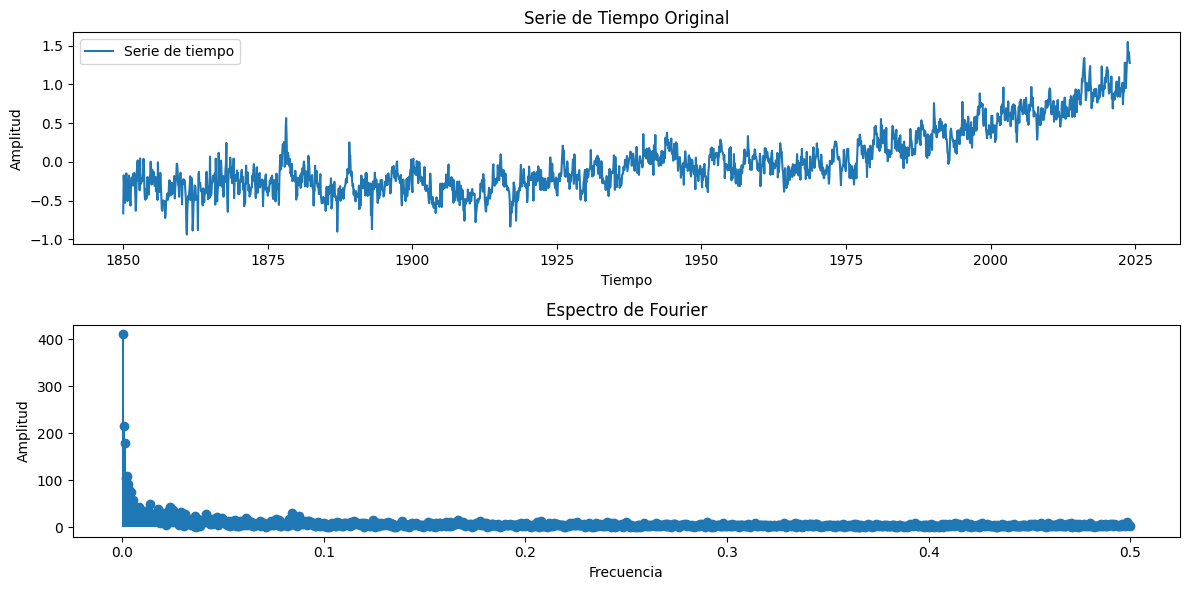

In [21]:
# Calcular la Transformada de Fourier Discreta
fourier_transform = np.fft.fft(temperature_mean)
frequencies = np.fft.fftfreq(len(temperature_mean), d=1)

# Obtener las amplitudes y filtrar frecuencias positivas
amplitudes = np.abs(fourier_transform)
positive_frequencies = frequencies > 0

# Graficar la serie de tiempo original
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot( temperature_mean, label="Serie de tiempo")
plt.title("Serie de Tiempo Original")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.legend()

# Graficar el espectro de Fourier
plt.subplot(2, 1, 2)
plt.stem(frequencies[positive_frequencies], amplitudes[positive_frequencies], basefmt=" ", use_line_collection=True)
plt.title("Espectro de Fourier")
plt.xlabel("Frecuencia")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()


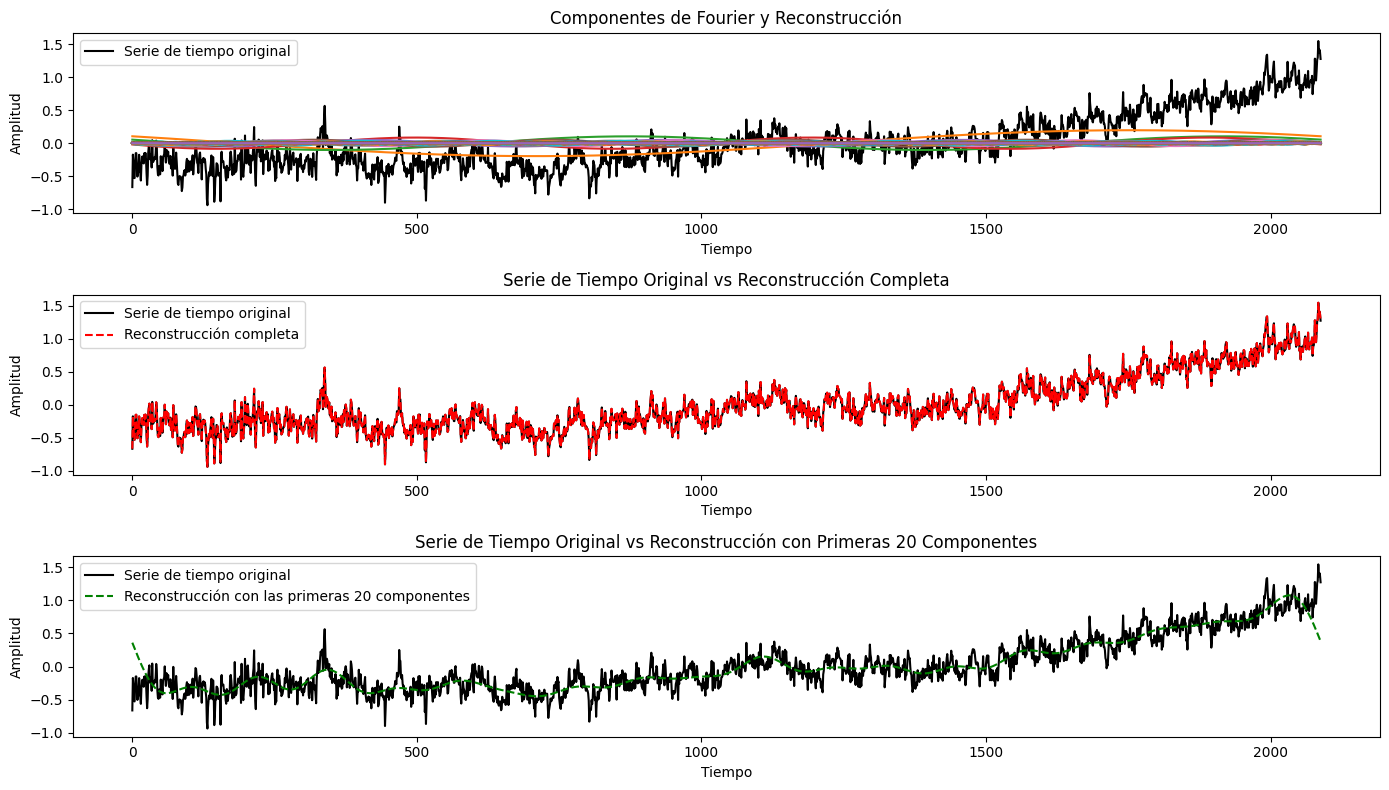

In [22]:
t = np.arange(len(temperature_mean))

# Calcular la Transformada de Fourier Discreta
fourier_transform = np.fft.fft(temperature_mean)
n = temperature_mean.size
frequencies = np.fft.fftfreq(n, d=1)  # Asumiendo que el paso de tiempo entre datos es 1

# Preparar la reconstrucción de la serie de tiempo a partir de los componentes de Fourier
reconstruccion = np.zeros_like(temperature_mean)
reconstruccion_10 = np.zeros_like(temperature_mean)  # Para las primeras 10 componentes

# Graficar la serie de tiempo original
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(t, temperature_mean, label="Serie de tiempo original", color='black')
plt.title("Componentes de Fourier y Reconstrucción")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.legend()

# Graficar cada componente y sumar para la reconstrucción
for idx, freq in enumerate(frequencies):
    if idx <= n // 2 and np.abs(fourier_transform[idx]) > 1e-10:  # Filtrar componentes irrelevantes
        amplitude = np.abs(fourier_transform[idx]) / n
        phase = np.angle(fourier_transform[idx])
        componente = amplitude * np.cos(2 * np.pi * freq * t + phase)
        reconstruccion += componente * 2  # Sumar el doble de cada componente porque la mitad va para frecuencias negativas
        if idx < 20:
            reconstruccion_10 += componente * 2  # Sumar solo las primeras 10 componentes
        plt.plot(t, componente, label=f"Componente {idx+1}") if idx < 10 else plt.plot(t, componente)  # Etiquetar solo las primeras 10

# Graficar la reconstrucción completa
plt.subplot(3, 1, 2)
plt.plot(t, temperature_mean, label="Serie de tiempo original", color='black')
plt.plot(t, reconstruccion, label="Reconstrucción completa", linestyle='--', color='red')
plt.title("Serie de Tiempo Original vs Reconstrucción Completa")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.legend()

# Graficar la reconstrucción usando solo las primeras 10 componentes
plt.subplot(3, 1, 3)
plt.plot(t, temperature_mean, label="Serie de tiempo original", color='black')
plt.plot(t, reconstruccion_10, label="Reconstrucción con las primeras 20 componentes", linestyle='--', color='green')
plt.title("Serie de Tiempo Original vs Reconstrucción con Primeras 20 Componentes")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()


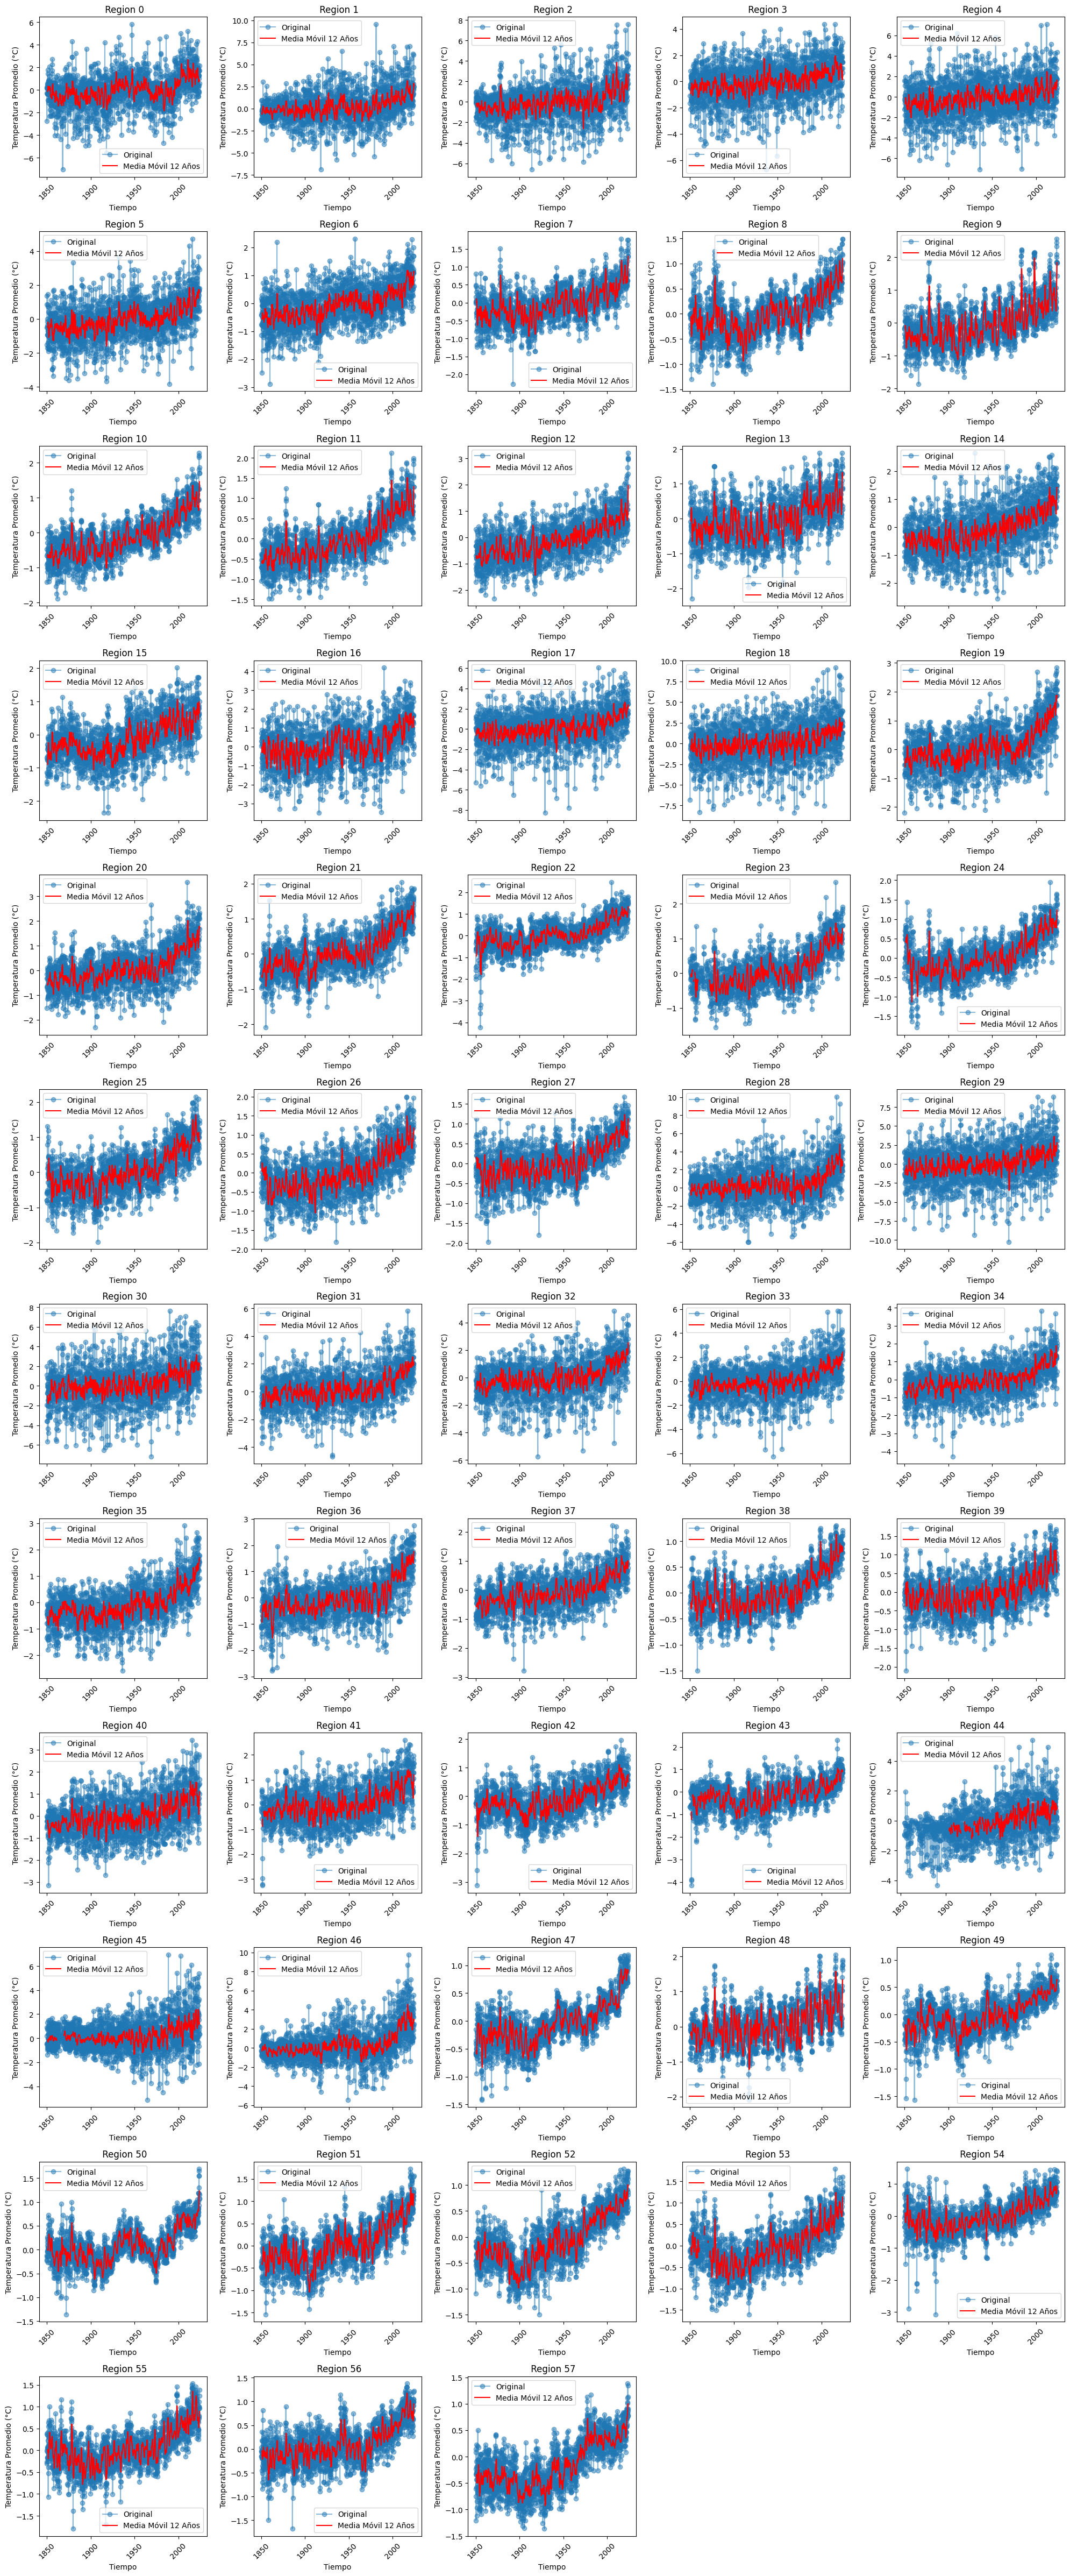

In [23]:


# Número de gráficas por fila
plots_per_row = 5

# Calcular el número total de filas necesarias
num_regions = len(temp_regions.columns)
total_rows = math.ceil(num_regions / plots_per_row)

# Crear una figura para acomodar todas las subgráficas
plt.figure(figsize=(20, total_rows * 4))  # Ajusta el tamaño de la figura según necesites

for i, column in enumerate(temp_regions.columns, start=1):
    ax = plt.subplot(total_rows, plots_per_row, i)
    
    # Plotear la serie de tiempo original
    ax.plot(temp_regions.index, temp_regions[column], label='Original', marker='o', linestyle='-', alpha=0.5)
    
    # Calcular y plotear la media móvil de 12 años
    moving_average = temp_regions[column].rolling(window=12).mean()
    ax.plot(temp_regions.index, moving_average, label='Media Móvil 12 Años', color='red', linestyle='-')
    
    # Configurar título, leyendas y ejes para cada subgráfico
    ax.set_title(f' {column}')
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('Temperatura Promedio (°C)')
    ax.legend()
    plt.xticks(rotation=45)

# Ajustar el layout para asegurar que no haya superposición de gráficos
plt.tight_layout()
plt.show()


In [3]:
url = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Complete_TAVG_daily.txt"

# Hacemos la solicitud al URL
response = requests.get(url)

# Verificamos que la respuesta sea exitosa
if response.status_code == 200:
    # Convertimos el texto de la respuesta en un objeto StringIO
    data = StringIO(response.text)
    
    # Definimos los nombres de las columnas según la descripción de los datos
    column_names = ['Date Number', 'Year', 'Month', 'Day', 'Day of Year', 'Anomaly']
    
    # Utilizamos pandas para leer los datos de formato de ancho fijo
    df = pd.read_fwf(data, colspecs='infer', names=column_names, skiprows=23)  # Asumimos que las primeras 22 líneas son metadatos
    print(df.head())  # Imprimimos las primeras filas para verificar
else:
    print("Error al descargar el archivo, código de estado:", response.status_code)

   Date Number  Year  Month  Day  Day of Year  Anomaly
0     1880.001  1880      1    1            1   -0.692
1     1880.004  1880      1    2            2   -0.592
2     1880.007  1880      1    3            3   -0.673
3     1880.010  1880      1    4            4   -0.615
4     1880.012  1880      1    5            5   -0.681


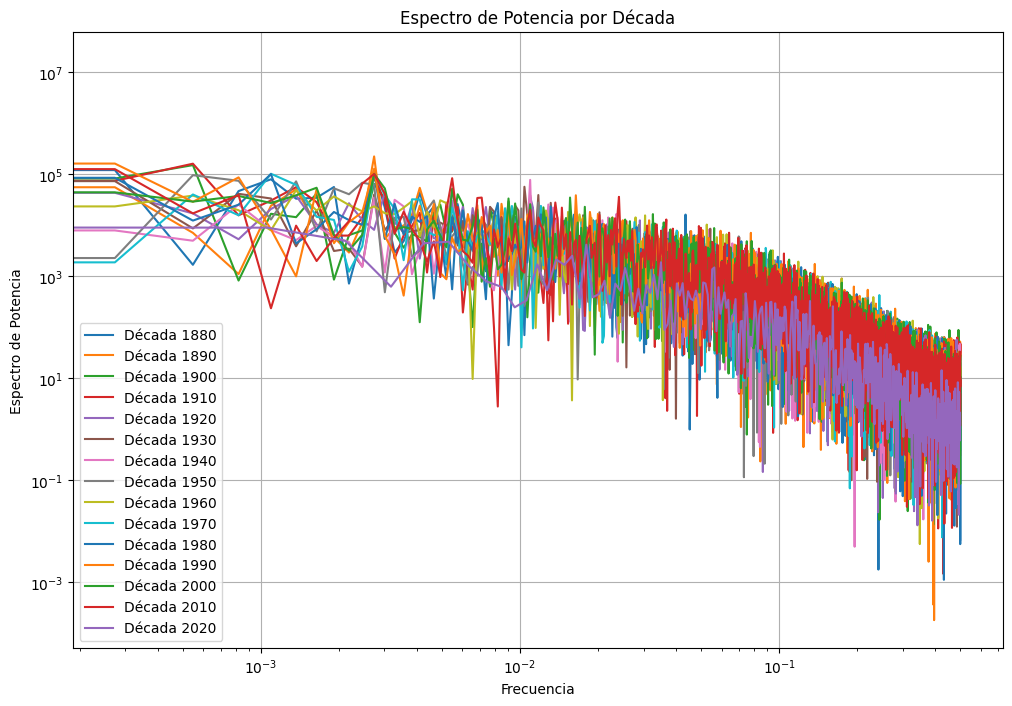

In [14]:
# Definimos las décadas
df['Decade'] = (df['Year'] // 10) * 10

# Inicializamos un diccionario para almacenar los resultados de cada década
power_spectrum_by_decade = {}

# Vamos a iterar sobre cada década única
for decade in df['Decade'].unique():
    # Filtramos los datos por década
    df_decade = df[df['Decade'] == decade]
    
    # Obtenemos la serie de anomalías para esta década
    anomalies = df_decade['Anomaly'].values
    
    # Aplicamos la transformada de Fourier para obtener el espectro de potencia
    fft_values = np.fft.fft(anomalies)
    power_spectrum = np.abs(fft_values) ** 2
    
    # Guardamos el espectro de potencia de esta década
    power_spectrum_by_decade[decade] = power_spectrum

# Ahora vamos a graficar el espectro de potencia para cada década
plt.figure(figsize=(12, 8))

for decade, power_spectrum in power_spectrum_by_decade.items():
    # Graficamos el espectro de potencia
    freqs = np.fft.fftfreq(len(power_spectrum))
    plt.loglog(freqs[:len(freqs)//2], power_spectrum[:len(power_spectrum)//2], label=f'Década {decade}')

plt.xlabel('Frecuencia')
plt.ylabel('Espectro de Potencia')
plt.title('Espectro de Potencia por Década')
plt.legend()
plt.grid(True)
plt.show()


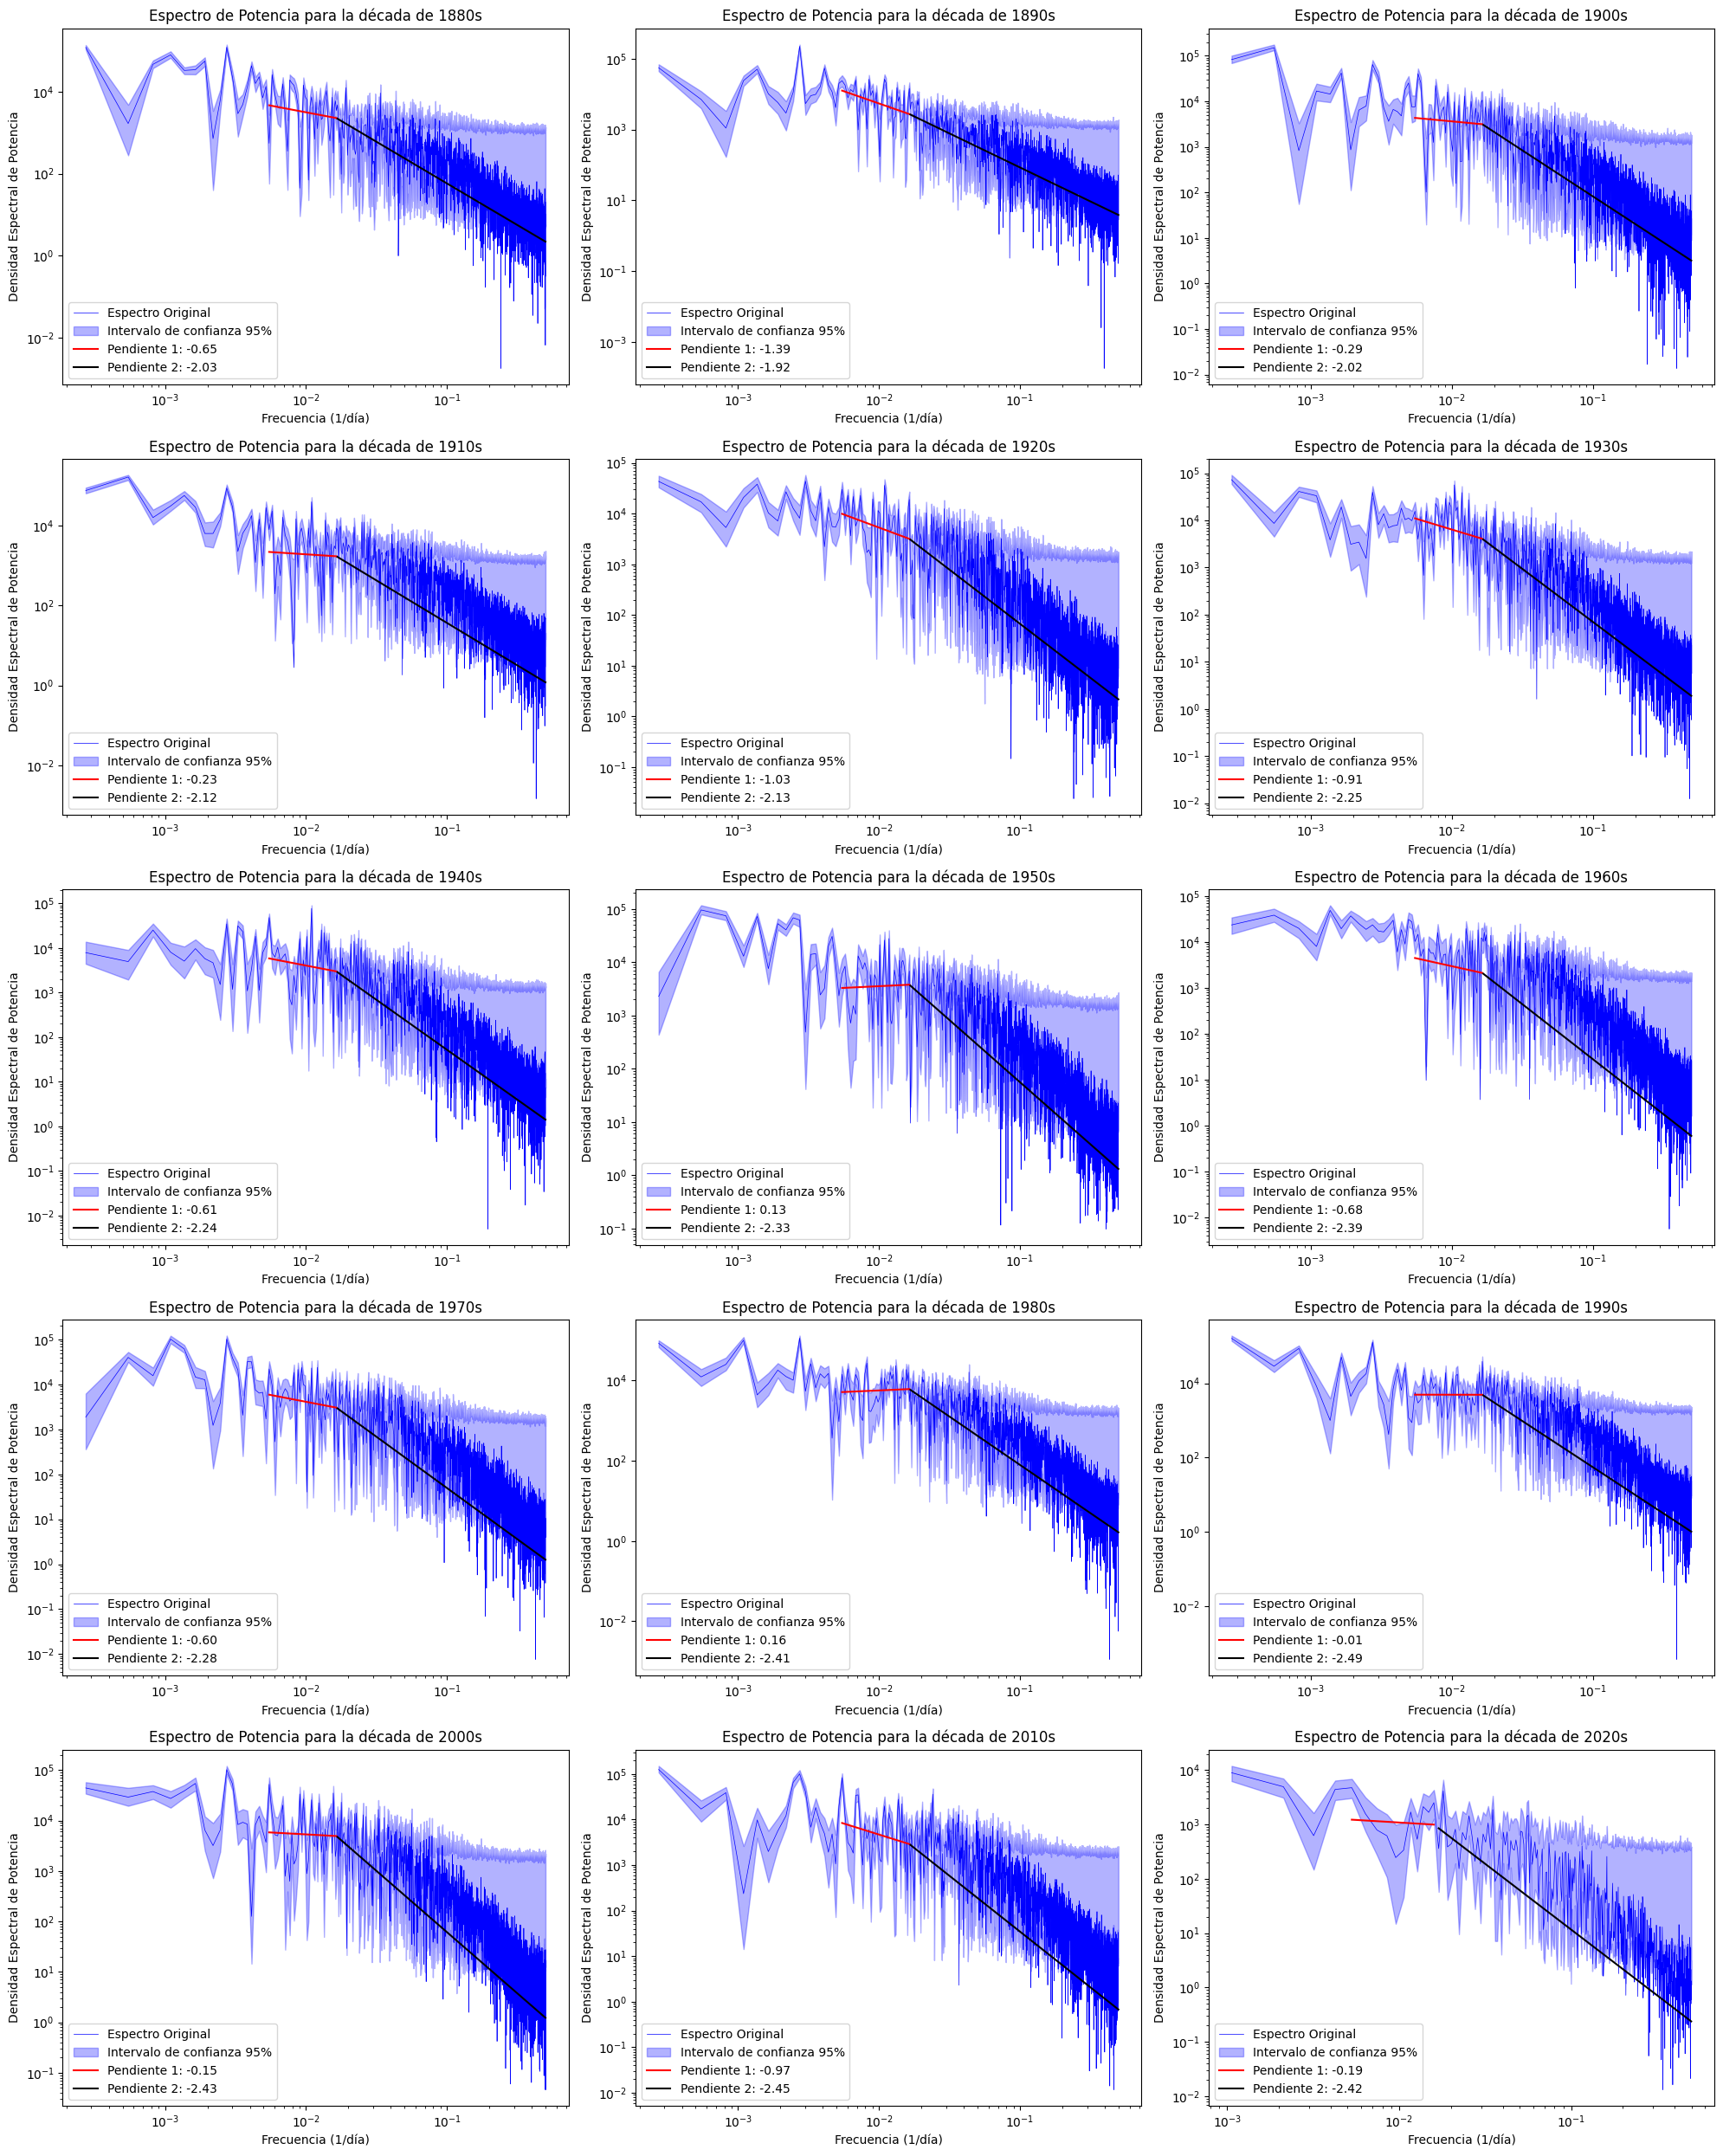

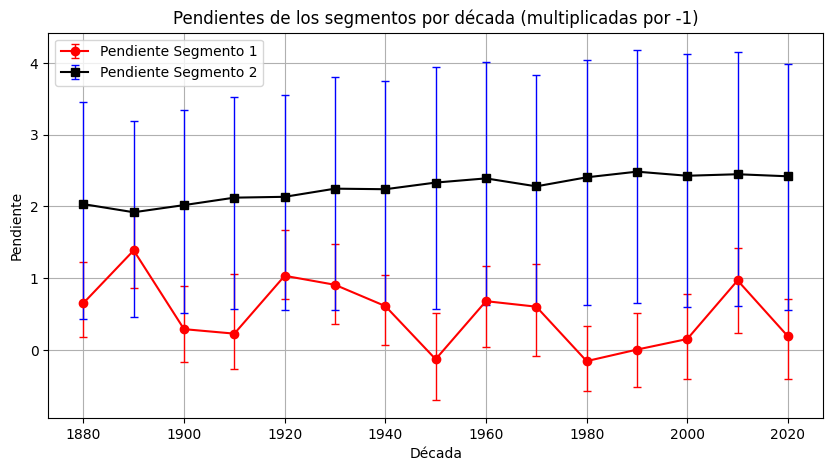

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Supongamos que df ya está definido y contiene las columnas 'Anomaly', 'Year', 'Month'
# Asegúrate de que 'Month' es una columna numérica que va de 1 a 12

# Crear la columna 'Decade' para agrupar por décadas
df['Decade'] = (df['Year'] // 10) * 10

# Calcular la desviación estándar por mes y década
monthly_std = df.groupby(['Year', 'Month'])['Anomaly'].std().reset_index()
monthly_std.columns = ['Year', 'Month', 'Std']

# Unir la desviación estándar al DataFrame original
df = pd.merge(df, monthly_std, on=['Year', 'Month'], how='left')

# Número de gráficas por fila
plots_per_row = 3

# Calcular el número total de décadas y filas necesarias
unique_decades = df['Decade'].unique()
total_rows = math.ceil(len(unique_decades) / plots_per_row)

# Listas para almacenar las pendientes de cada segmento por década
slopes_segment_1 = []
slopes_segment_2 = []

# Diccionarios para almacenar las pendientes de cada realización por década
slopes_segment_1_realizations = {decade: [] for decade in unique_decades}
slopes_segment_2_realizations = {decade: [] for decade in unique_decades}

# Crear una figura para acomodar todas las subgráficas
plt.figure(figsize=(20, total_rows * 5))

for i, decade in enumerate(unique_decades, start=1):
    ax = plt.subplot(total_rows, plots_per_row, i)
    decade_data = df[df['Decade'] == decade]
    anomaly_data = decade_data['Anomaly'].values
    std_data = decade_data['Std'].values
    n_samples = len(anomaly_data)

    # Calcular el espectro de potencia original
    fft_result_original = np.fft.fft(anomaly_data)
    frequencies = np.fft.fftfreq(n_samples, d=1)
    power_spectrum_original = np.abs(fft_result_original) ** 2
    positive_freqs = frequencies > 0
    frequencies = frequencies[positive_freqs]
    power_spectrum_original = power_spectrum_original[positive_freqs]

    # Generar 200 realizaciones aleatorias para cada día
    n_realizations = 200
    random_anomalies = np.random.normal(
        loc=anomaly_data[:, np.newaxis],
        scale=std_data[:, np.newaxis],
        size=(n_samples, n_realizations)
    )

    # Inicializar una matriz para almacenar los espectros de potencia
    power_spectra = np.zeros((len(frequencies), n_realizations))

    # Inicializar listas para almacenar las pendientes de cada realización
    slopes_1 = []
    slopes_2 = []

    # Calcular el espectro de potencia y las pendientes para cada realización
    for j in range(n_realizations):
        realization = random_anomalies[:, j]
        fft_result = np.fft.fft(realization)
        power_spectrum = np.abs(fft_result) ** 2
        power_spectrum = power_spectrum[positive_freqs]
        power_spectra[:, j] = power_spectrum

        # Calcular las pendientes para esta realización
        # Analiza rangos de frecuencia

        # 1.5 to 6 months
        freq_45_days = 1 / 60
        freq_180_days = 1 / 180
        index_45_days = np.argmin(np.abs(frequencies - freq_45_days))
        index_180_days = np.argmin(np.abs(frequencies - freq_180_days))

        if index_45_days > index_180_days:
            freq_range_1 = frequencies[index_180_days:index_45_days]
            power_range_1 = power_spectrum[index_180_days:index_45_days]
            log_freq_1 = np.log10(freq_range_1)
            log_power_1 = np.log10(power_range_1)
            slope_1, _ = np.polyfit(log_freq_1, log_power_1, 1)
        else:
            slope_1 = np.nan

        # 0 to 1 month
        freq_1_day = 1 / 1
        index_1_day = np.argmin(np.abs(frequencies - freq_1_day))

        if index_1_day > index_45_days:
            freq_range_2 = frequencies[index_45_days:index_1_day]
            power_range_2 = power_spectrum[index_45_days:index_1_day]
            log_freq_2 = np.log10(freq_range_2)
            log_power_2 = np.log10(power_range_2)
            slope_2, _ = np.polyfit(log_freq_2, log_power_2, 1)
        else:
            slope_2 = np.nan

        slopes_1.append(slope_1)
        slopes_2.append(slope_2)

    # Calcular la mediana y los intervalos de confianza para el espectro de potencia
    median_power = np.median(power_spectra, axis=1)
    lower_bound = np.percentile(power_spectra, 2.5, axis=1)
    upper_bound = np.percentile(power_spectra, 97.5, axis=1)

    # Graficar el espectro de potencia original
    ax.loglog(frequencies, power_spectrum_original, 'b-', linewidth=0.5, label='Espectro Original')

    # Graficar los intervalos de confianza
    ax.fill_between(frequencies, lower_bound, upper_bound, color='blue', alpha=0.3, label='Intervalo de confianza 95%')

    # Calcular las pendientes para el espectro original
    # 1.5 to 6 months
    if index_45_days > index_180_days:
        freq_range_1 = frequencies[index_180_days:index_45_days]
        power_range_1 = power_spectrum_original[index_180_days:index_45_days]
        log_freq_1 = np.log10(freq_range_1)
        log_power_1 = np.log10(power_range_1)
        slope_1_orig, intercept_1 = np.polyfit(log_freq_1, log_power_1, 1)

        # Guardar la pendiente del primer segmento
        slopes_segment_1.append(slope_1_orig)

        ax.loglog(freq_range_1, 10**(intercept_1 + slope_1_orig * log_freq_1), 'r-', label=f'Pendiente 1: {slope_1_orig:.2f}')
    else:
        slope_1_orig = np.nan
        slopes_segment_1.append(slope_1_orig)

    # Obtener el punto final de la primera recta
    last_freq = freq_range_1[-1]
    last_power = 10**(intercept_1 + slope_1_orig * np.log10(last_freq))

    # 0 to 1 month
    if index_1_day > index_45_days:
        freq_range_2 = frequencies[index_45_days:index_1_day]
        power_range_2 = power_spectrum_original[index_45_days:index_1_day]
        log_freq_2 = np.log10(freq_range_2)
        log_power_2 = np.log10(power_range_2)
        slope_2_orig, _ = np.polyfit(log_freq_2, log_power_2, 1)

        # Ajustar la segunda recta para que comience en el punto final de la primera
        intercept_2 = np.log10(last_power) - slope_2_orig * np.log10(last_freq)

        # Guardar la pendiente del segundo segmento
        slopes_segment_2.append(slope_2_orig)

        ax.loglog(freq_range_2, 10**(intercept_2 + slope_2_orig * log_freq_2), 'k-', label=f'Pendiente 2: {slope_2_orig:.2f}')
    else:
        slope_2_orig = np.nan
        slopes_segment_2.append(slope_2_orig)

    # Almacenar las pendientes de las realizaciones
    slopes_segment_1_realizations[decade] = slopes_1
    slopes_segment_2_realizations[decade] = slopes_2

    # Configurar títulos y etiquetas
    ax.set_title(f'Espectro de Potencia para la década de {decade}s')
    ax.set_xlabel('Frecuencia (1/día)')
    ax.set_ylabel('Densidad Espectral de Potencia')
    ax.legend()

# Ajustar el diseño
plt.tight_layout()
plt.show()

# Convertir las pendientes a arrays y multiplicar por -1
slopes_segment_1 = np.array(slopes_segment_1) * -1
slopes_segment_2 = np.array(slopes_segment_2) * -1

# Calcular intervalos de confianza para las pendientes por década
slopes_1_ci_lower = []
slopes_1_ci_upper = []
slopes_2_ci_lower = []
slopes_2_ci_upper = []

for decade in unique_decades:
    s1_realizations = np.array(slopes_segment_1_realizations[decade]) * -1
    s2_realizations = np.array(slopes_segment_2_realizations[decade]) * -1

    # Remover valores nan si los hay
    s1_realizations = s1_realizations[~np.isnan(s1_realizations)]
    s2_realizations = s2_realizations[~np.isnan(s2_realizations)]

    # Calcular percentiles
    s1_lower = np.percentile(s1_realizations, 2.5)
    s1_upper = np.percentile(s1_realizations, 97.5)
    s2_lower = np.percentile(s2_realizations, 2.5)
    s2_upper = np.percentile(s2_realizations, 97.5)

    slopes_1_ci_lower.append(s1_lower)
    slopes_1_ci_upper.append(s1_upper)
    slopes_2_ci_lower.append(s2_lower)
    slopes_2_ci_upper.append(s2_upper)

# Convertir listas a arrays numpy
slopes_1_ci_lower = np.array(slopes_1_ci_lower)
slopes_1_ci_upper = np.array(slopes_1_ci_upper)
slopes_2_ci_lower = np.array(slopes_2_ci_lower)
slopes_2_ci_upper = np.array(slopes_2_ci_upper)

# Corregir los límites de los intervalos de confianza si están invertidos
slopes_1_ci_lower_corrected = np.minimum(slopes_1_ci_lower, slopes_1_ci_upper)
slopes_1_ci_upper_corrected = np.maximum(slopes_1_ci_lower, slopes_1_ci_upper)
slopes_2_ci_lower_corrected = np.minimum(slopes_2_ci_lower, slopes_2_ci_upper)
slopes_2_ci_upper_corrected = np.maximum(slopes_2_ci_lower, slopes_2_ci_upper)

# Calcular errores para las barras de error
slopes_1_lower_err = np.abs(slopes_segment_1 - slopes_1_ci_lower_corrected)
slopes_1_upper_err = np.abs(slopes_1_ci_upper_corrected - slopes_segment_1)
slopes_2_lower_err = np.abs(slopes_segment_2 - slopes_2_ci_lower_corrected)
slopes_2_upper_err = np.abs(slopes_2_ci_upper_corrected - slopes_segment_2)

# Crear una gráfica de las pendientes de los segmentos por década con barras de error diferenciadas
plt.figure(figsize=(10, 5))

# Pendiente Segmento 1 con barras de error en rojo
plt.errorbar(unique_decades, slopes_segment_1,
             yerr=[slopes_1_lower_err, slopes_1_upper_err],
             fmt='o-', color='r', ecolor='r', elinewidth=1, capsize=3, label='Pendiente Segmento 1')

# Pendiente Segmento 2 con barras de error en azul
plt.errorbar(unique_decades, slopes_segment_2,
             yerr=[slopes_2_lower_err, slopes_2_upper_err],
             fmt='s-', color='k', ecolor='blue', elinewidth=1, capsize=3, label='Pendiente Segmento 2')

plt.xlabel('Década')
plt.ylabel('Pendiente')
plt.title('Pendientes de los segmentos por década (multiplicadas por -1)')
plt.legend()
plt.grid(True)
plt.show()


ValueError: could not broadcast input array from shape (3630,) into shape (3653,)

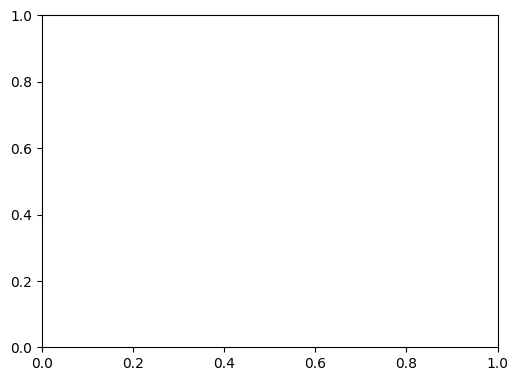

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Supongamos que df ya está definido y contiene las columnas 'Anomaly', 'Year'
df['Decade'] = (df['Year'] // 10) * 10

# Número de gráficas por fila
plots_per_row = 3

# Calcular el número total de décadas y filas necesarias
unique_decades = df['Decade'].unique()
total_rows = math.ceil(len(unique_decades) / plots_per_row)

# Listas para almacenar las pendientes de cada segmento por década
slopes_segment_1 = []
slopes_segment_2 = []

# Crear una figura para acomodar todas las subgráficas
plt.figure(figsize=(20, total_rows * 5))

for i, decade in enumerate(unique_decades, start=1):
    ax = plt.subplot(total_rows, plots_per_row, i)
    decade_data = df[df['Decade'] == decade]['Anomaly'].values
    n_samples = len(decade_data)

    # Número de realizaciones bootstrap
    n_realizations = 200
    block_size = 30  # Tamaño del bloque en días (ajusta según sea necesario)

    # Inicializar una matriz para almacenar los espectros de potencia
    power_spectra = np.zeros((n_samples, n_realizations))

    # Generar realizaciones bootstrap
    for j in range(n_realizations):
        # Crear índices para los bloques
        indices = np.arange(0, n_samples - block_size + 1, block_size)
        np.random.shuffle(indices)
        bootstrap_series = []

        for idx in indices:
            block = decade_data[idx:idx + block_size]
            bootstrap_series.extend(block)

        # Asegurar que la serie bootstrap tenga el mismo tamaño
        bootstrap_series = np.array(bootstrap_series[:n_samples])

        # Calcular el espectro de potencia
        fft_result = np.fft.fft(bootstrap_series)
        power_spectrum = np.abs(fft_result) ** 2
        power_spectra[:, j] = power_spectrum

    # Frecuencias
    frequencies = np.fft.fftfreq(n_samples, d=1)
    positive_freqs = frequencies > 0
    frequencies = frequencies[positive_freqs]
    power_spectra = power_spectra[positive_freqs, :]

    # Calcular la mediana y los intervalos de confianza
    median_power = np.median(power_spectra, axis=1)
    lower_bound = np.percentile(power_spectra, 2.5, axis=1)
    upper_bound = np.percentile(power_spectra, 97.5, axis=1)

    # Graficar el espectro de potencia mediano y los intervalos de confianza
    ax.loglog(frequencies, median_power, 'b-', linewidth=0.5, label='Mediana')
    ax.fill_between(frequencies, lower_bound, upper_bound, color='blue', alpha=0.3, label='Intervalo de confianza 95%')

    # Espectro de potencia original
    fft_result_original = np.fft.fft(decade_data)
    power_spectrum_original = np.abs(fft_result_original) ** 2
    power_spectrum_original = power_spectrum_original[positive_freqs]
    ax.loglog(frequencies, power_spectrum_original, 'g--', linewidth=0.5, label='Original')

    # Analiza rangos de frecuencia

    # 1.5 to 6 months
    freq_45_days = 1 / 60
    freq_180_days = 1 / 180
    index_45_days = np.argmin(np.abs(frequencies - freq_45_days))
    index_180_days = np.argmin(np.abs(frequencies - freq_180_days))

    if index_45_days > index_180_days:
        freq_range_1 = frequencies[index_180_days:index_45_days]
        power_range_1 = median_power[index_180_days:index_45_days]
        log_freq_1 = np.log10(freq_range_1)
        log_power_1 = np.log10(power_range_1)
        slope_1, intercept_1 = np.polyfit(log_freq_1, log_power_1, 1)

        # Guardar la pendiente del primer segmento
        slopes_segment_1.append(slope_1)

        ax.loglog(freq_range_1, 10**(intercept_1 + slope_1 * log_freq_1), 'r-', label=f'Pendiente 1: {slope_1:.2f}')

    # Obtener el punto final de la primera recta
    last_freq = freq_range_1[-1]
    last_power = 10**(intercept_1 + slope_1 * np.log10(last_freq))

    # 0 to 1 month (a partir del final de la primera recta)
    freq_1_day = 1 / 1
    index_1_day = np.argmin(np.abs(frequencies - freq_1_day))

    if index_1_day > index_45_days:
        freq_range_2 = frequencies[index_45_days:index_1_day]
        power_range_2 = median_power[index_45_days:index_1_day]
        log_freq_2 = np.log10(freq_range_2)
        log_power_2 = np.log10(power_range_2)

        # Ajustar la segunda recta para que comience en el punto final de la primera
        slope_2, _ = np.polyfit(log_freq_2, log_power_2, 1)

        # Calcular el nuevo intercepto para que la segunda recta inicie donde terminó la primera
        intercept_2 = np.log10(last_power) - slope_2 * np.log10(last_freq)

        # Guardar la pendiente del segundo segmento
        slopes_segment_2.append(slope_2)

        ax.loglog(freq_range_2, 10**(intercept_2 + slope_2 * log_freq_2), 'k-', label=f'Pendiente 2: {slope_2:.2f}')

    # Configurar títulos y etiquetas
    ax.set_title(f'Espectro de Potencia para la década de {decade}s')
    ax.set_xlabel('Frecuencia (1/día)')
    ax.set_ylabel('Densidad Espectral de Potencia')
    ax.legend()

# Ajustar el diseño
plt.tight_layout()
plt.show()

# Crear una gráfica de las pendientes de los segmentos por década
plt.figure(figsize=(10, 5))
plt.plot(unique_decades, slopes_segment_1, 'o-', color='r', label='Pendiente Segmento 1')
plt.plot(unique_decades, slopes_segment_2, 'o-', color='k', label='Pendiente Segmento 2')
plt.xlabel('Década')
plt.ylabel('Pendiente')
plt.title('Pendientes de los segmentos por década corte a 60 días')
plt.legend()
plt.grid(True)
plt.show()


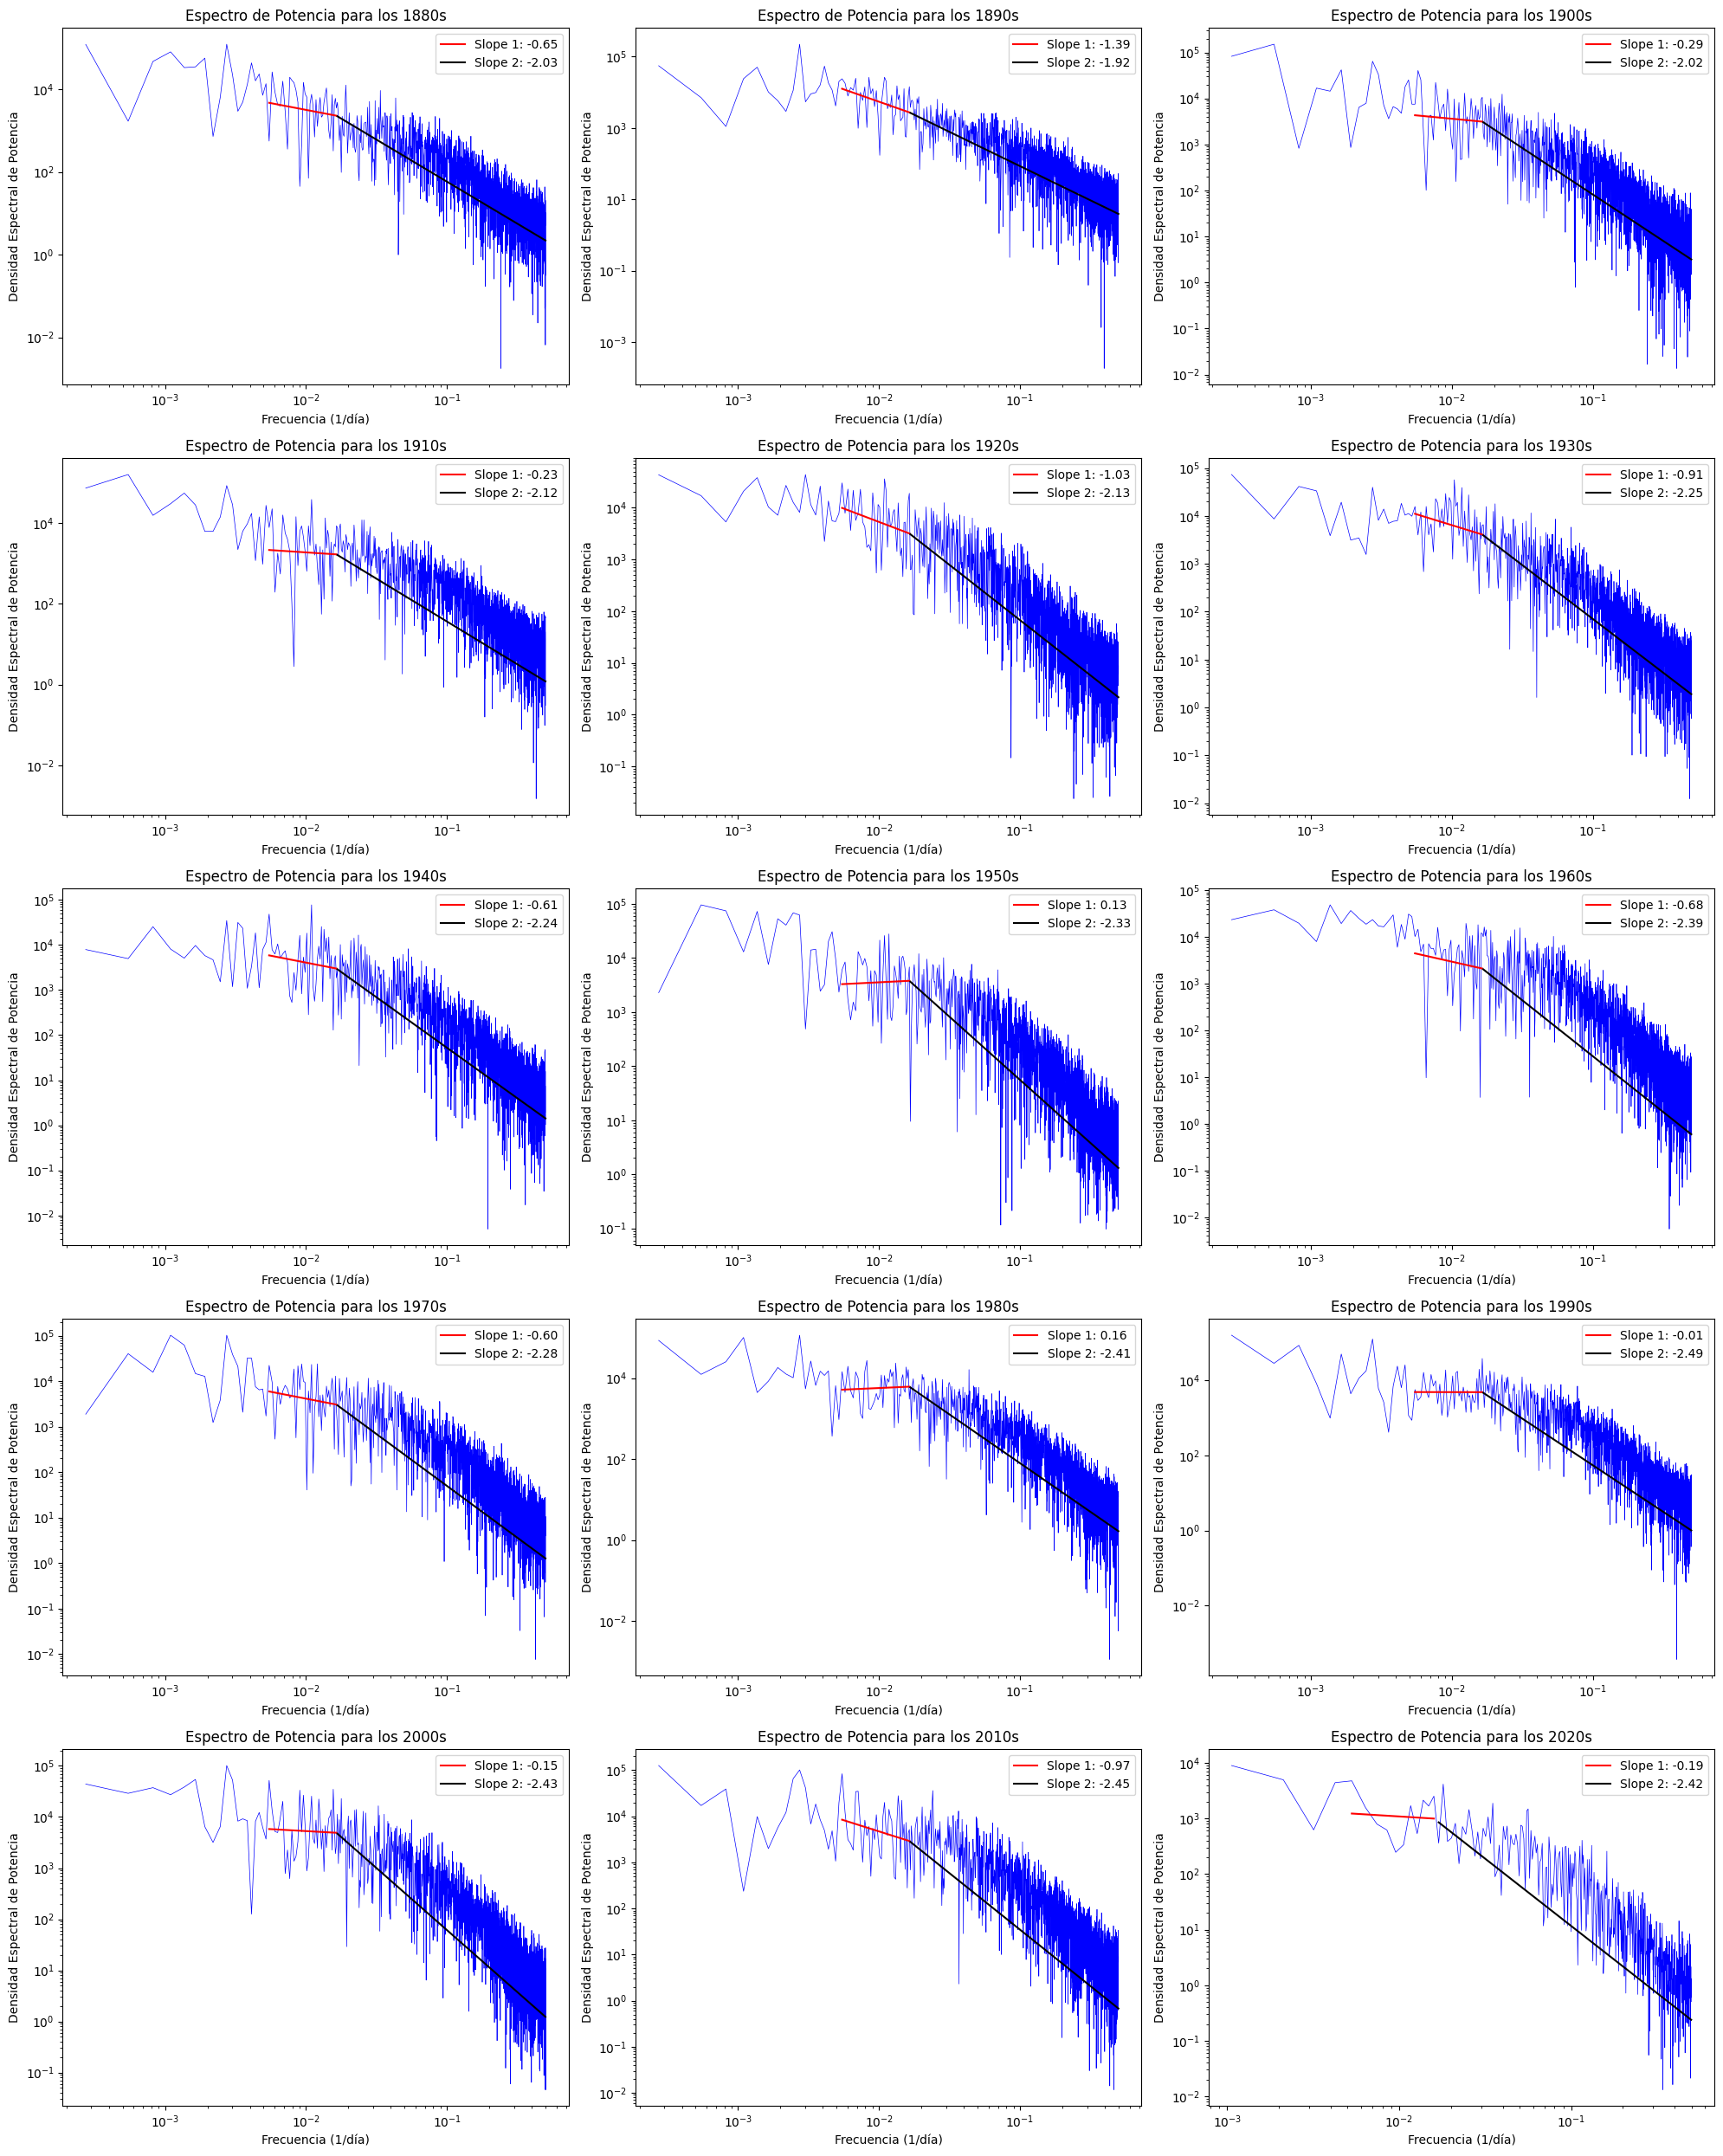

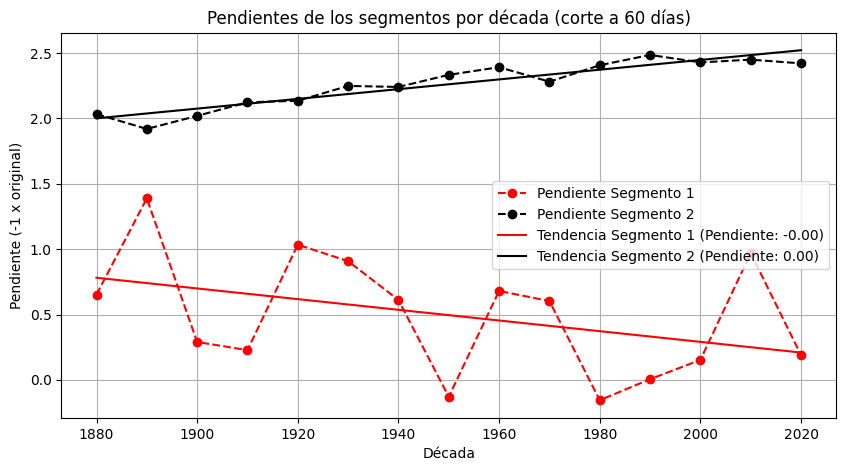

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Supongamos que df ya está definido y contiene la columna 'Anomaly' para cada década
df['Decade'] = (df['Year'] // 10) * 10

# Número de gráficas por fila
plots_per_row = 3

# Calcular el número total de décadas y filas necesarias
unique_decades = np.sort(df['Decade'].unique())
total_rows = math.ceil(len(unique_decades) / plots_per_row)

# Listas para almacenar las pendientes de cada segmento por década
slopes_segment_1 = []
slopes_segment_2 = []
decades_with_slopes = []

# Crear una figura para acomodar todas las subgráficas
plt.figure(figsize=(20, total_rows * 5))

for i, decade in enumerate(unique_decades, start=1):
    ax = plt.subplot(total_rows, plots_per_row, i)
    decade_data = df[df['Decade'] == decade]['Anomaly']
    
    # Verificar si hay suficientes datos para realizar la FFT
    if len(decade_data) < 2:
        continue  # Saltar si no hay suficientes datos
    
    # FFT y frecuencias
    fft_result = np.fft.fft(decade_data)
    frequencies = np.fft.fftfreq(len(decade_data), d=1)
    power_spectrum = np.abs(fft_result) ** 2

    # Plot del espectro de potencia
    ax.loglog(frequencies[frequencies > 0], power_spectrum[frequencies > 0], 'b-', linewidth=0.5)

    # Analiza rangos de frecuencia

    # 1.5 a 6 meses
    freq_45_days = 1 / 60
    freq_180_days = 1 / 180
    index_45_days = np.argmin(np.abs(frequencies - freq_45_days))
    index_180_days = np.argmin(np.abs(frequencies - freq_180_days))

    if index_45_days > index_180_days:
        freq_range_1 = frequencies[index_180_days:index_45_days]
        power_range_1 = power_spectrum[index_180_days:index_45_days]
        log_freq_1 = np.log10(freq_range_1)
        log_power_1 = np.log10(power_range_1)
        slope_1, intercept_1 = np.polyfit(log_freq_1, log_power_1, 1)

        # Guardar la pendiente del primer segmento
        slopes_segment_1.append(slope_1)
        decades_with_slopes.append(decade)

        ax.loglog(freq_range_1, 10**(intercept_1 + slope_1 * log_freq_1), 'r-', label=f'Slope 1: {slope_1:.2f}')

    # Obtener el punto final de la primera recta
    last_freq = freq_range_1[-1]
    last_power = 10**(intercept_1 + slope_1 * np.log10(last_freq))

    # 0 a 1 mes (a partir del final de la primera recta)
    freq_1_day = 1 / 1
    index_1_day = np.argmin(np.abs(frequencies - freq_1_day))

    if index_1_day > index_45_days:
        freq_range_2 = frequencies[index_45_days:index_1_day]
        power_range_2 = power_spectrum[index_45_days:index_1_day]
        log_freq_2 = np.log10(freq_range_2)
        log_power_2 = np.log10(power_range_2)
        
        # Ajustar la segunda recta
        slope_2, _ = np.polyfit(log_freq_2, log_power_2, 1)
        
        # Calcular el nuevo intercepto
        intercept_2 = np.log10(last_power) - slope_2 * np.log10(last_freq)
        
        # Guardar la pendiente del segundo segmento
        slopes_segment_2.append(slope_2)
        
        ax.loglog(freq_range_2, 10**(intercept_2 + slope_2 * log_freq_2), 'k-', label=f'Slope 2: {slope_2:.2f}')

    # Configurar títulos y etiquetas
    ax.set_title(f'Espectro de Potencia para los {decade}s')
    ax.set_xlabel('Frecuencia (1/día)')
    ax.set_ylabel('Densidad Espectral de Potencia')
    ax.legend()

# Ajustar el diseño y mostrar las gráficas
plt.tight_layout()
plt.show()

# Multiplicar las pendientes por -1 solo en la gráfica de pendientes por década
slopes_segment_1_neg = [-s for s in slopes_segment_1]
slopes_segment_2_neg = [-s for s in slopes_segment_2]

# Crear una gráfica de las pendientes de los segmentos por década con líneas punteadas y línea de tendencia
plt.figure(figsize=(10, 5))

# Plot de las pendientes con líneas punteadas
plt.plot(decades_with_slopes, slopes_segment_1_neg, 'o--', color='r', label='Pendiente Segmento 1')
plt.plot(decades_with_slopes, slopes_segment_2_neg, 'o--', color='k', label='Pendiente Segmento 2')

# Agregar líneas de tendencia
# Para segmento 1
if len(decades_with_slopes) >= 2:
    z1 = np.polyfit(decades_with_slopes, slopes_segment_1_neg, 1)
    p1 = np.poly1d(z1)
    plt.plot(decades_with_slopes, p1(decades_with_slopes), 'r-', label=f'Tendencia Segmento 1 (Pendiente: {z1[0]:.2f})')

# Para segmento 2
if len(decades_with_slopes) >= 2:
    z2 = np.polyfit(decades_with_slopes, slopes_segment_2_neg, 1)
    p2 = np.poly1d(z2)
    plt.plot(decades_with_slopes, p2(decades_with_slopes), 'k-', label=f'Tendencia Segmento 2 (Pendiente: {z2[0]:.2f})')

plt.xlabel('Década')
plt.ylabel('Pendiente (-1 x original)')
plt.title('Pendientes de los segmentos por década (corte a 60 días)')
plt.legend()
plt.grid(True)
plt.show()


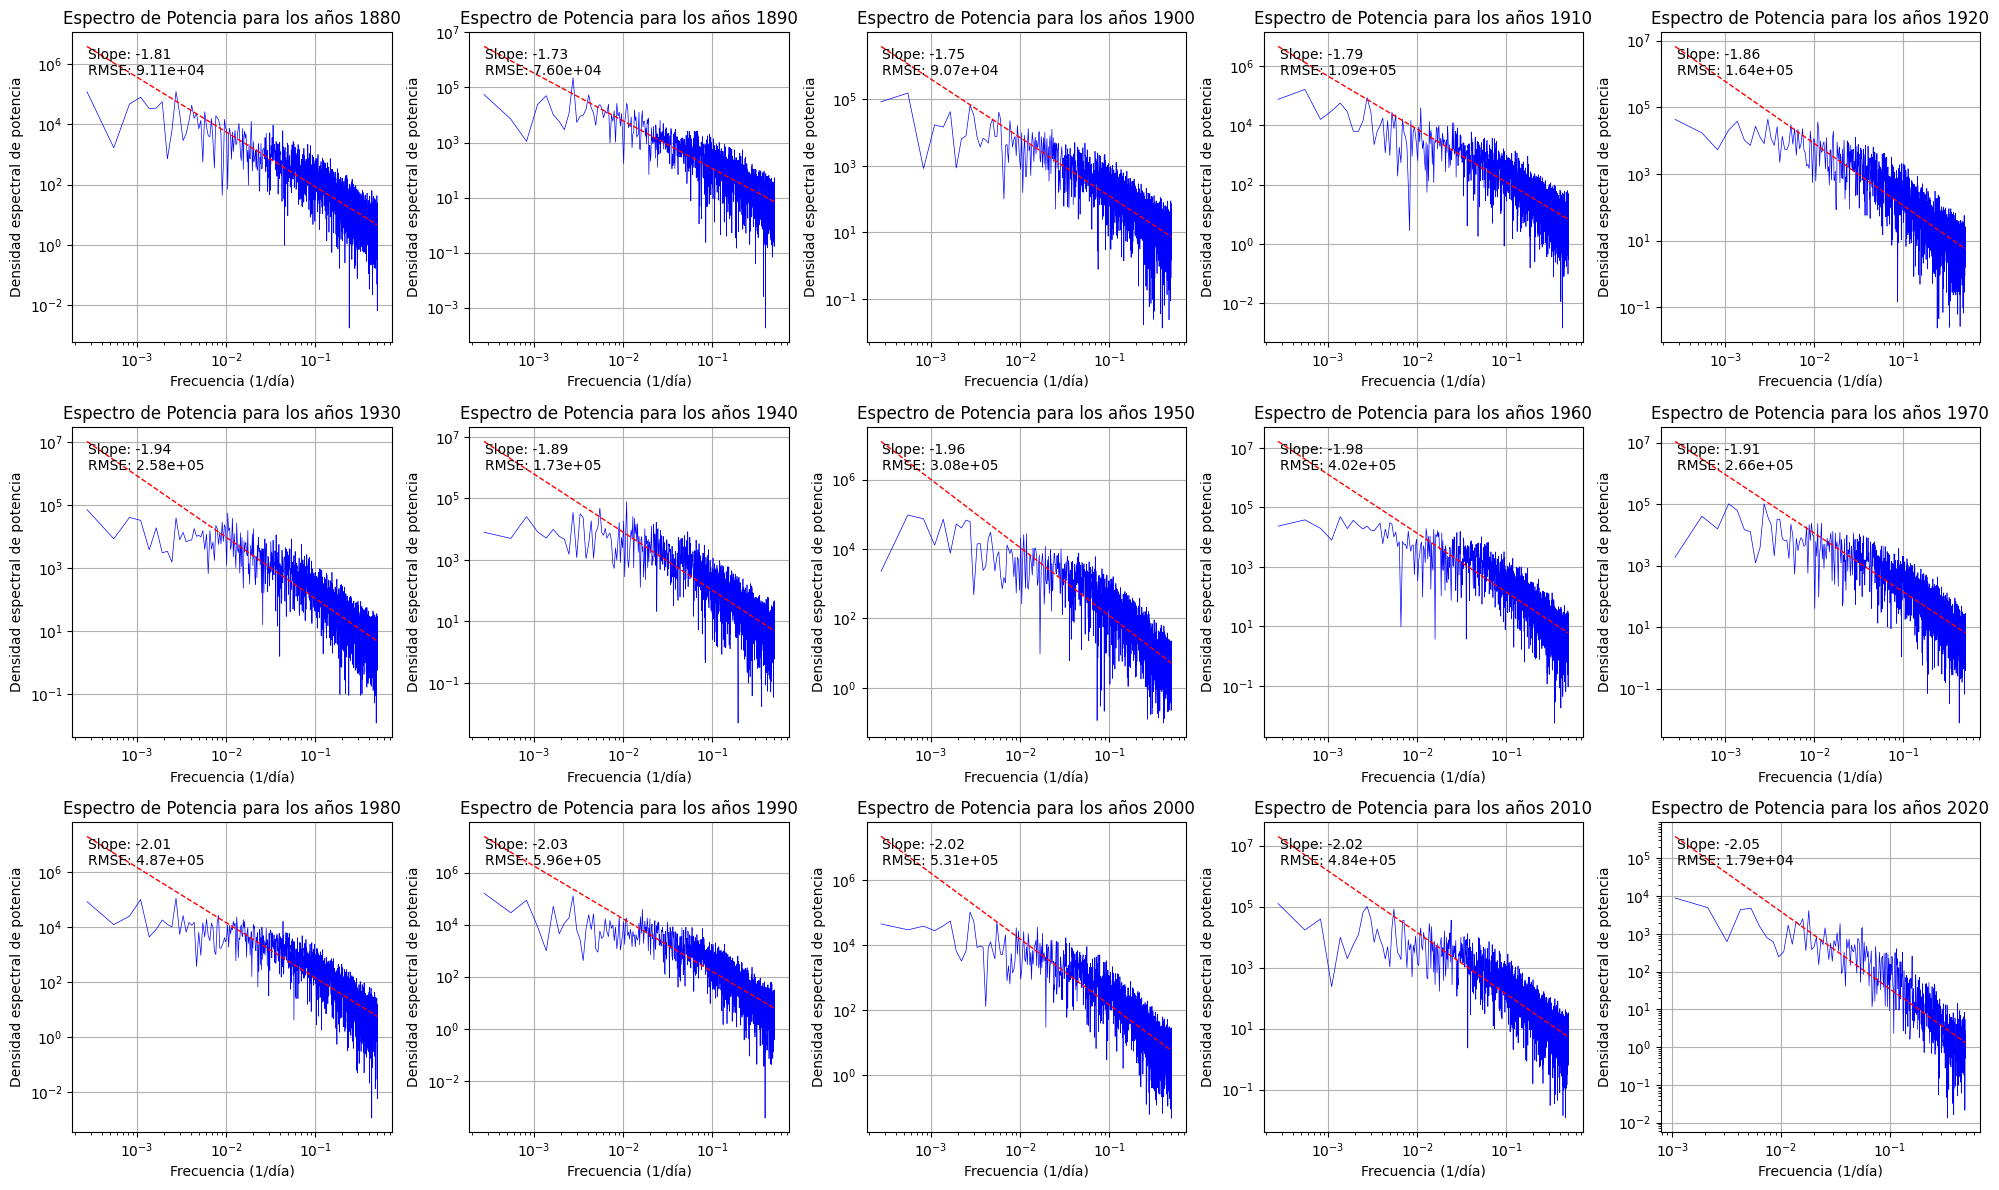

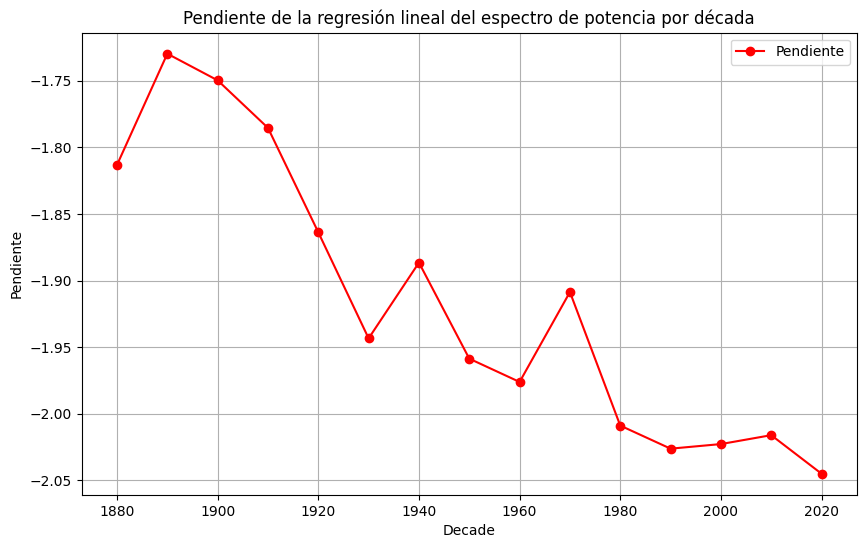

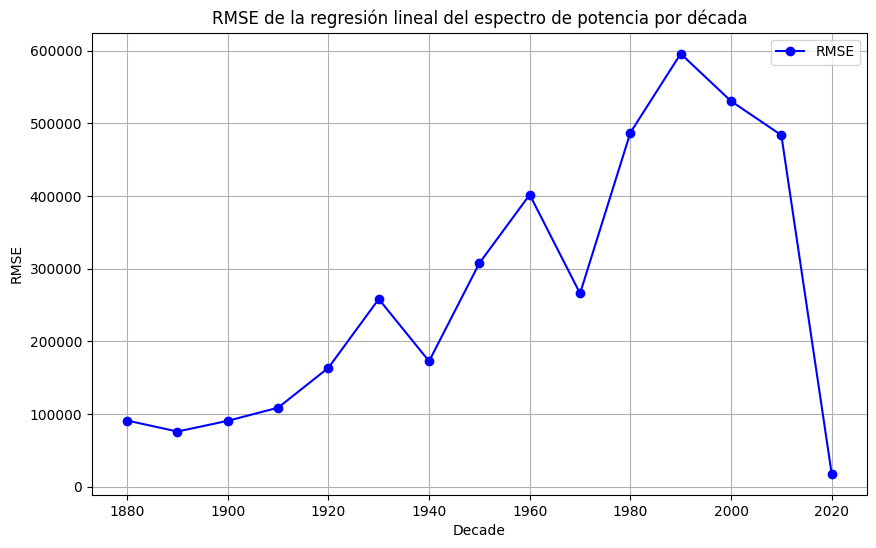

In [ ]:
from scipy.stats import linregress



# Agrupar los datos por décadas
df['Decade'] = (df['Year'] // 10) * 10  # Crea una nueva columna para la década

# Número de gráficas por fila
plots_per_row = 5

# Calcular el número total de décadas y filas necesarias
unique_decades = np.sort(df['Decade'].unique())
total_rows = math.ceil(len(unique_decades) / plots_per_row)

# Crear una figura para acomodar todas las subgráficas
plt.figure(figsize=(20, total_rows * 4))  # Ajusta el tamaño de la figura según necesites

# Lista para almacenar las pendientes y los RMSE
slopes = []
rmses = []

for i, decade in enumerate(unique_decades, start=1):
    ax = plt.subplot(total_rows, plots_per_row, i)
    decade_data = df[df['Decade'] == decade]['Anomaly']
    
    # Calcular la transformada rápida de Fourier (FFT) y las frecuencias
    fft_result = np.fft.fft(decade_data)
    frequencies = np.fft.fftfreq(len(decade_data), d=1)  # d=1 asumiendo datos diarios
    
    # Calcular el espectro de potencia (magnitud al cuadrado)
    power_spectrum = np.abs(fft_result) ** 2
    
    # Filtrar solo frecuencias positivas
    positive_frequencies = frequencies[frequencies > 0]
    positive_power_spectrum = power_spectrum[frequencies > 0]
    
    # Graficar el espectro de potencia en escala log-log
    ax.loglog(positive_frequencies, positive_power_spectrum, 'b-', linewidth=0.5)
    
    # Aplicar la regresión lineal en el espacio log-log
    log_frequencies = np.log10(positive_frequencies)
    log_power_spectrum = np.log10(positive_power_spectrum)
    
    slope, intercept, r_value, p_value, std_err = linregress(log_frequencies, log_power_spectrum)
    
    # Calcular los valores ajustados
    predicted_log_power_spectrum = intercept + slope * log_frequencies
    predicted_power_spectrum = 10**predicted_log_power_spectrum
    
    # Calcular el RMSE
    rmse = np.sqrt(np.mean((positive_power_spectrum - predicted_power_spectrum) ** 2))
    rmses.append(rmse)
    
    # Graficar la línea de regresión
    ax.loglog(positive_frequencies, 10**predicted_log_power_spectrum, 'r--', linewidth=1)

    # Mostrar la pendiente y el RMSE en el gráfico
    ax.text(0.05, 0.95, f'Slope: {slope:.2f}\nRMSE: {rmse:.2e}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Configurar título, leyendas y ejes para cada subgráfico
    ax.set_title(f'Espectro de Potencia para los años {decade}')
    ax.set_xlabel('Frecuencia (1/día)')
    ax.set_ylabel('Densidad espectral de potencia')
    ax.grid(True)
    
    # Almacenar la pendiente
    slopes.append(slope)

# Ajustar el layout para asegurar que no haya superposición de gráficos
plt.tight_layout()
plt.show()

# Graficar la pendiente de la regresión lineal para cada década
plt.figure(figsize=(10, 6))
plt.plot(unique_decades, slopes, 'o-', color='red', label='Pendiente')
plt.xlabel('Decade')
plt.ylabel('Pendiente')
plt.title('Pendiente de la regresión lineal del espectro de potencia por década')
plt.grid(True)
plt.legend()
plt.show()

# Graficar el RMSE de la regresión lineal para cada década
plt.figure(figsize=(10, 6))
plt.plot(unique_decades, rmses, 'o-', color='blue', label='RMSE')
plt.xlabel('Decade')
plt.ylabel('RMSE')
plt.title('RMSE de la regresión lineal del espectro de potencia por década')
plt.grid(True)
plt.legend()
plt.show()
